# Importar las Librerias, Cargar los Datos Preprocesados

In [ ]:
import pandas as pd
import numpy as np
import pandas.util.testing as tm
import matplotlib.pyplot as plt
import seaborn as sn
import random

from pandas.api.types import is_numeric_dtype
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

#librerias para modelos de clasificacion
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, kneighbors_graph
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import statsmodels.api as srm

#para graficar el arbol de decision
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 
from IPython.display import Image 
from pydot import graph_from_dot_data

#librerias para la validacion y obtener metricas
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,roc_curve, auc,r2_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_validate

#guardar modelos entrenados
from joblib import dump, load
import os


In [ ]:
ruta_data_set = 'Data/BankloanFULL2021_preprocess.xlsx'
data_set = pd.read_excel(ruta_data_set, sheet_name='Sheet1', index_col=0)

In [ ]:
data_set.head()

,Edad,Prom_NumTarjCred,Prom_NumTransWeb,LN_Ingreso,LN_Prom_CreditMes,LN_Prom_MargenComp,Genero_M,FUGA_NF,EstCivil_Casado_si,NivelEduc_Univ_si
0,0.230769,0.222222,0.002445,0.250369,0.098192,0.591422,1,1,0,1
1,0.353846,0.000000,0.004890,0.171057,0.095832,0.597611,0,1,1,0
2,0.153846,0.111111,0.000000,0.227254,0.120531,0.580333,0,1,0,1
3,0.476923,0.111111,0.000000,0.289353,0.063720,0.607018,1,1,1,0
4,0.615385,0.111111,0.044010,0.186191,0.081556,0.601114,0,1,0,0


Eliminar las Variables las cuales fueron transformadas a logaritmos

In [ ]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5605 entries, 0 to 5604
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Edad                5605 non-null   float64
 1   Prom_NumTarjCred    5605 non-null   float64
 2   Prom_NumTransWeb    5605 non-null   float64
 3   LN_Ingreso          5605 non-null   float64
 4   LN_Prom_CreditMes   5605 non-null   float64
 5   LN_Prom_MargenComp  5605 non-null   float64
 6   Genero_M            5605 non-null   int64  
 7   FUGA_NF             5605 non-null   int64  
 8   EstCivil_Casado_si  5605 non-null   int64  
 9   NivelEduc_Univ_si   5605 non-null   int64  
dtypes: float64(6), int64(4)
memory usage: 481.7 KB


In [ ]:
data_set.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Edad,5605.0,0.321265,0.139208,0.0,0.215385,0.276923,0.400000,1.0
Prom_NumTarjCred,5605.0,0.092517,0.077947,0.0,0.037037,0.111111,0.111111,1.0
Prom_NumTransWeb,5605.0,0.034151,0.067639,0.0,0.000000,0.012225,0.036675,1.0
LN_Ingreso,5605.0,0.278286,0.119710,0.0,0.194956,0.252809,0.338515,1.0
LN_Prom_CreditMes,5605.0,0.079881,0.045459,0.0,0.061749,0.066880,0.077846,1.0
LN_Prom_MargenComp,5605.0,0.600590,0.021106,0.0,0.594586,0.597817,0.605165,1.0
Genero_M,5605.0,0.700089,0.458260,0.0,0.000000,1.000000,1.000000,1.0
FUGA_NF,5605.0,0.872257,0.333833,0.0,1.000000,1.000000,1.000000,1.0
EstCivil_Casado_si,5605.0,0.528457,0.499234,0.0,0.000000,1.000000,1.000000,1.0
NivelEduc_Univ_si,5605.0,0.647636,0.477749,0.0,0.000000,1.000000,1.000000,1.0


# Arreglo de Desbalance de las Muestras

Para arreglar el desbalanceo de los datos, ya que se puede observar que existe un total de 4889 valores No Fugados contra un total de 716 valores Fugados. Por lo que, para balancear los datos, se completará la columna 0 para llegar a un total de 4889 observaciones, esto se realizará de forma aleatoria escogiendo observaciones del dentro del subconjunto de observaciones en donde el cliente si se fuga, es decir, dentro de una base de 716 posibles datos.

Por lo que la siguiente accion a tomar es el de crear dos data sets diferentes, uno balanceado y otro desbalanceado. El data set balanceado será utilizado para entrenar a los modelos, mientras que el modelo desbalanceado, es decir, los datos como provienen desde la base de datos sin ser alterados, será utilizado para posteriormente poder evaluar el rendimineto de los modelos y determinar cual es el mejor que se logra ajustar mejor a los datos.

In [ ]:
data_set['FUGA_NF'].value_counts()

1    4889
0     716
Name: FUGA_NF, dtype: int64

In [ ]:
data_set

4173

In [ ]:
copy_df = data_set[data_set['FUGA_NF'] == 0]
copy_df_index = [index for index in copy_df.index]

rows_list = []
for iteration in range(0, 4173):
  num = random.choice(copy_df_index)
  row = copy_df.loc[num, :]
  rows_list.append(row)

df = pd.DataFrame(rows_list)

copy_df = pd.concat([copy_df, df], axis=0)
copy_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4889 entries, 4889 to 5355
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Edad                4889 non-null   float64
 1   Prom_NumTarjCred    4889 non-null   float64
 2   Prom_NumTransWeb    4889 non-null   float64
 3   LN_Ingreso          4889 non-null   float64
 4   LN_Prom_CreditMes   4889 non-null   float64
 5   LN_Prom_MargenComp  4889 non-null   float64
 6   Genero_M            4889 non-null   float64
 7   FUGA_NF             4889 non-null   float64
 8   EstCivil_Casado_si  4889 non-null   float64
 9   NivelEduc_Univ_si   4889 non-null   float64
dtypes: float64(10)
memory usage: 420.1 KB


In [ ]:
df1 = data_set[data_set['FUGA_NF'] == 1]
copy_df

# Data_set de Entrenamiento con los Datos BALANCEADOS, reemplaza a data_set original
data_set = pd.concat([df1, copy_df], axis=0)

# Separación de los Datos usando Train-Test

In [ ]:
# Datos Balanceados

y = data_set['FUGA_NF']
data_set.drop('FUGA_NF', axis=1, inplace=True)
X = data_set

In [ ]:
# Datos Balanceados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
X_test.shape

(2934, 9)

# Entrenamiento y Validación de los Modelos

## Regresión Logística

Dentro de las ventajas de realizar una regresión logística para un modelo de clasificación dado que los datos no se encuentran estandarizados, hace que sea más facil la interpretación ya que los coeficientes se encuentran en unidades de la variable dependiente y.

La estrategia para esta clase de modelo es realizar diversar regresiones hasta lograr encontrar la que mejor estime el modelo, y descartando las variables cuyos p-values sean superiores a 0.05, este proceso de eliminación se realiza una por una.

In [ ]:
logit_model = srm.Logit(y_train, srm.add_constant(X_train))

In [ ]:
results_00 = logit_model.fit()

print(results_00.summary2())

Optimization terminated successfully.
         Current function value: 0.495382
         Iterations 8
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.285    
Dependent Variable:   FUGA_NF           AIC:               6800.7896
Date:                 2021-06-01 17:15  BIC:               6869.1008
No. Observations:     6844              Log-Likelihood:    -3390.4  
Df Model:             9                 LL-Null:           -4743.9  
Df Residuals:         6834              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
--------------------------------------------------------------------
const              -10.1386   1.1724 -8.6476 0.0000 -12.4365 -7.8407
Edad                 0.3729 

Ya que el proceso de busqueda resulta iterativo, se creará una lista que almacene el nombre de las variables que han sido descartadas para el modelo de regresión logistico debido a su alto p-value, y una función que realice el proceso de realizar el modelo e imprimir el resumen de los datos.

In [ ]:
# Lista de Variables No Consideradas para el Modelo
not_considered = []


def logistic_model(X_train, y_train):
  logit_model = srm.Logit(y_train, srm.add_constant(X_train))
  results = logit_model.fit()
  print(results.summary2())


def columns_remaining_list(X_train):
  return [cols for cols in X_train.columns if cols not in not_considered]

Eliminando la variable:
- Edad

In [ ]:
not_considered.append('Edad')

In [ ]:
X_train_reg01 = X_train[columns_remaining_list(X_train)]
X_test_reg01 = X_test[columns_remaining_list(X_test)]
logistic_model(X_train_reg01, y_train)

Optimization terminated successfully.
         Current function value: 0.495553
         Iterations 8
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.285    
Dependent Variable:   FUGA_NF           AIC:               6801.1249
Date:                 2021-06-01 17:16  BIC:               6862.6050
No. Observations:     6844              Log-Likelihood:    -3391.6  
Df Model:             8                 LL-Null:           -4743.9  
Df Residuals:         6835              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
--------------------------------------------------------------------
const              -10.1566   1.1770 -8.6291 0.0000 -12.4635 -7.8497
Prom_NumTarjCred    15.6599 

Eliminando la variable:
- EstCivil_Casado_si

In [ ]:
not_considered.append('EstCivil_Casado_si')

In [ ]:
X_train_reg02 = X_train[columns_remaining_list(X_train)]
X_test_reg02 = X_test[columns_remaining_list(X_test)]
logistic_model(X_train_reg02, y_train)

Optimization terminated successfully.
         Current function value: 0.495839
         Iterations 8
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.285    
Dependent Variable:   FUGA_NF           AIC:               6803.0454
Date:                 2021-06-01 17:16  BIC:               6857.6945
No. Observations:     6844              Log-Likelihood:    -3393.5  
Df Model:             7                 LL-Null:           -4743.9  
Df Residuals:         6836              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
--------------------------------------------------------------------
const              -10.1010   1.1720 -8.6185 0.0000 -12.3981 -7.8039
Prom_NumTarjCred    15.6843 

Eliminando la variable:
- NivelEduc_Univ_si

In [ ]:
not_considered.append('NivelEduc_Univ_si')

In [ ]:
X_train_reg03 = X_train[columns_remaining_list(X_train)]
X_test_reg03 = X_test[columns_remaining_list(X_test)]
logistic_model(X_train_reg03, y_train)

Optimization terminated successfully.
         Current function value: 0.496109
         Iterations 8
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.284    
Dependent Variable:   FUGA_NF           AIC:               6804.7364
Date:                 2021-06-01 17:16  BIC:               6852.5543
No. Observations:     6844              Log-Likelihood:    -3395.4  
Df Model:             6                 LL-Null:           -4743.9  
Df Residuals:         6837              LLR p-value:       0.0000   
Converged:            1.0000            Scale:             1.0000   
No. Iterations:       8.0000                                        
--------------------------------------------------------------------
                    Coef.   Std.Err.    z    P>|z|   [0.025   0.975]
--------------------------------------------------------------------
const              -10.1022   1.1710 -8.6271 0.0000 -12.3973 -7.8071
Prom_NumTarjCred    15.7051 

Con las variables que quedan, en los valores de los p-value para el test individual de cada variable si es que es significativa para el modelo, todas las variables no significativas fueron removidas.

In [ ]:
regresion = LogisticRegression(random_state=0)
regresion.fit(X_train_reg03, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pd.DataFrame(zip(X_train_reg03.columns, np.transpose(regresion.coef_.tolist()[0])),columns=['features','coef'])

,features,coef
0,Prom_NumTarjCred,13.824468
1,Prom_NumTransWeb,7.497916
2,LN_Ingreso,-1.658605
3,LN_Prom_CreditMes,9.600265
4,LN_Prom_MargenComp,3.526341
5,Genero_M,0.088555


## Árboles de Decisión

Lo primero en hacer es determinar cuales son los mejores parámetros que se adecuen. Para esto se utilizará el método de GridSearch para determinar cuales son los mejores parámetros.

Crean una variable que contenga el modelo de Arbol de decisión

In [ ]:
arbol = DecisionTreeClassifier()

Establecer los parámetros que serán utilizados en el Grid Search para determinar cuales se ajustan mejor al modelo de arbol de decisión.

In [ ]:
parametros= {'criterion': ['entropy', 'gini'], 'splitter': ['best', 'random'], 'max_leaf_nodes': [5,18,30], 'min_samples_split': [2, 3, 4], 'max_depth':[2,3,4]}

Realizar el Grid Search

In [ ]:
tree_cv=GridSearchCV(arbol,parametros,cv=10)
tree_cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                  

Imprimir los resultados de la busqueda de grilla

In [ ]:
print('Best params:')
print(tree_cv.best_params_)

Best params:
{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 18, 'min_samples_split': 2, 'splitter': 'best'}


Guardamos el mejor modelo de la grilla para luego obtener sus resultados de predicción

In [ ]:
arbol = DecisionTreeClassifier(criterion = 'entropy',max_depth= 2, max_leaf_nodes= 5, min_samples_split= 2, splitter='best')
arbol.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Best params:
{'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': 18, 'min_samples_split': 2, 'splitter': 'best'}



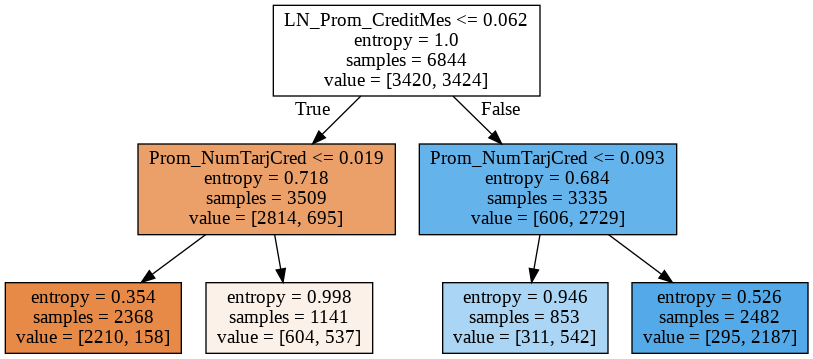

In [ ]:
#con estas funciones se grafica mas grande y es mas facil de leer
print('Best params:')
print(tree_cv.best_params_)
print()
dot_data = StringIO()
export_graphviz(arbol, out_file=dot_data, feature_names=data_set.columns,filled= True)
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [ ]:
#arbol = tree_cv.best_params_

## Paso Intermedio: Normalizar los Datos

Los modelos que vienen a continuación requieren que los datos se encuentren estandarizados o normalizados.


In [ ]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(data_set, y, test_size=0.3, random_state = 0)

## K-Vecinos mas cercanos

In [ ]:
Knn = KNeighborsClassifier()

In [ ]:
parametros= {'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'n_neighbors': [3,5,11,19], 'weights': ['uniform','distance'], 'metric':['euclidean','manhattan']}

In [ ]:
knn_cv=GridSearchCV(Knn,parametros,cv=10)
knn_cv.fit(X_train_scaled, y_train_scaled)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
print('Best params for k-neighborns:')
print(knn_cv.best_params_)

Best params for k-neighborns:
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [ ]:
Knn = knn_cv.best_estimator_

Best params for k-neighborns:
{'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


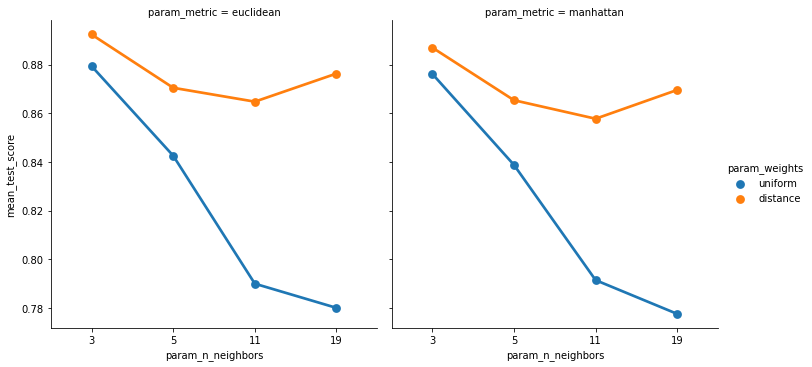

In [ ]:
print('Best params for k-neighborns:')
print(knn_cv.best_params_)
grid_results = pd.DataFrame(knn_cv.cv_results_)
sn.catplot(x="param_n_neighbors", y="mean_test_score", hue="param_weights", kind="point", col="param_metric",data=grid_results);


## Random forest

Best params for Random Forest:
{'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100}


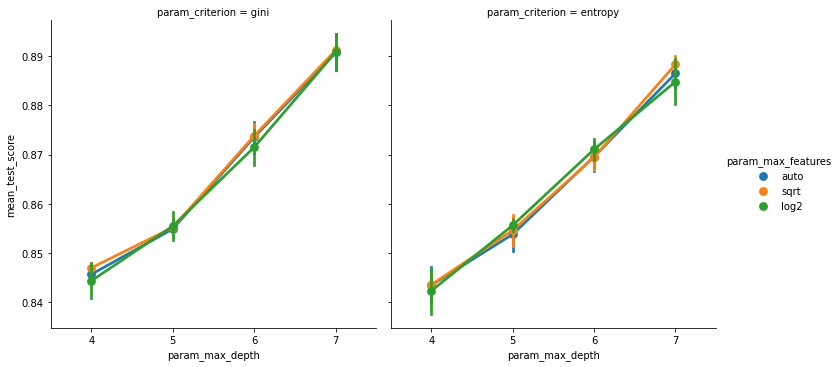

In [ ]:
rf = RandomForestClassifier()

#Determinamos los parametros a probar en la grilla
parametros={'criterion': ['gini', 'entropy'], 'n_estimators': [10, 100], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [4,5,6,7]}

#Realizamos la grilla
rf_cv=GridSearchCV(rf,parametros,cv=10)
rf_cv.fit(X_train_scaled, y_train_scaled)

#vemos los mejores parametros segun la grilla
print('Best params for Random Forest:')
print(rf_cv.best_params_)

#Guardamos el mejor modelo para luego obtener sus reusltados de validacion
rf = rf_cv.best_estimator_

#transformamos los resultados de la grilla en un dataframe
grid_results = pd.DataFrame(rf_cv.cv_results_)

#graficamos los puntaje obtenidos segun cada parametro analizado
sn.catplot(x="param_max_depth", y="mean_test_score", hue="param_max_features", kind="point", col="param_criterion",data=grid_results);


## Red Neuronal

In [ ]:
red = MLPClassifier(solver='lbfgs' ) 

#Determinamos los parametros a probar en la grilla

parametros={"batch_size": [5, 10, 20], 'activation': ['identity', 'logistic', 'tanh', 'relu'],
            'learning_rate':['constant', 'invscaling', 'adaptive'], 'max_iter': [50,100], 'alpha': [0.1, 0.01, 0.001],
            'hidden_layer_sizes':[(2,3),3,5]}

#Realizamos la grilla
red_cv=GridSearchCV(red,parametros,n_jobs=2,cv=10)
red_cv.fit(X_train_scaled, y_train_scaled)

#vemos los mejores parametros segun la grilla
print('Best params for neural network:')
print(red_cv.best_params_)

#Guardamos el mejor modelo para luego obtener sus resultados de validacion
red = red_cv.best_estimator_

Best params for neural network:
{'activation': 'tanh', 'alpha': 0.01, 'batch_size': 20, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'max_iter': 100}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [ ]:
! git clone https://github.com/jzliu-100/visualize-neural-network.git

Cloning into 'visualize-neural-network'...
remote: Enumerating objects: 61, done.
remote: Total 61 (delta 0), reused 0 (delta 0), pack-reused 61
Unpacking objects: 100% (61/61), done.


In [ ]:
! python /content/visualize-neural-network/VisualizeNN.py 
%cd /content/visualize-neural-network
!ls

/content/visualize-neural-network
img  README.md	testVisualizeNN.py  VisualizeNN.py


In [ ]:
print(red.hidden_layer_sizes)

3


In [ ]:
print(red.coefs_)

[array([[ 5.55487293e+00, -1.06016816e+00, -2.28735139e-01],
       [ 6.51730415e+00,  1.34394762e+00, -4.98807396e+00],
       [ 2.65968350e+00,  3.52263391e+00, -6.66544985e+00],
       [ 3.71939581e+00, -2.30838057e+00,  5.34361528e-01],
       [ 2.82974352e+00,  4.54533491e+00, -3.89301657e+01],
       [ 1.24843634e+01, -3.27020492e+00,  4.31619755e-01],
       [ 7.55429171e-01, -6.53737856e+00, -6.70857626e-02],
       [ 1.33540076e+00, -6.59029263e+00,  9.86432445e-03],
       [ 6.22848166e+00, -3.36793377e+00,  2.23442091e-02]]), array([[-20.09518801],
       [ -5.54705429],
       [-19.95475544]])]


Best params for neural network:
{'activation': 'tanh', 'alpha': 0.01, 'batch_size': 20, 'hidden_layer_sizes': 3, 'learning_rate': 'adaptive', 'max_iter': 100}



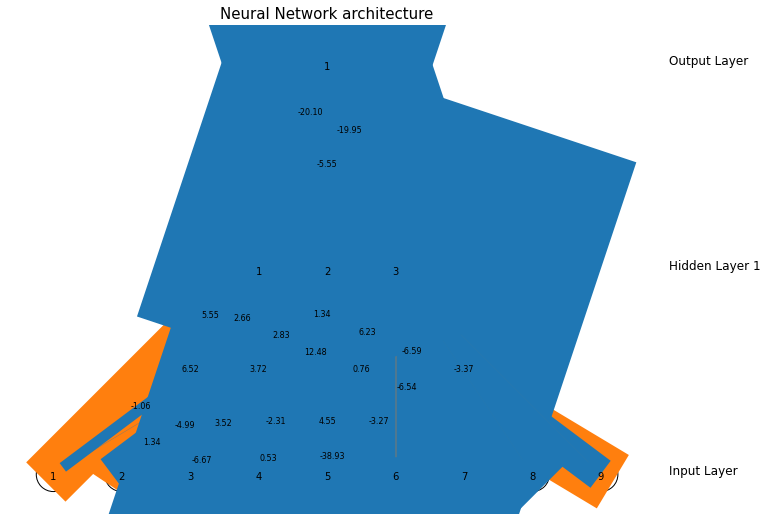

In [ ]:
import VisualizeNN as VisNN
print('Best params for neural network:')
print(red_cv.best_params_)
print()
network = VisNN.DrawNN([X_train_scaled.shape[1], red.hidden_layer_sizes, 1], red.coefs_)
network.draw()

## Support Vector Machine

Best params for SVM:
{'C': 100000.0, 'gamma': 0.01}


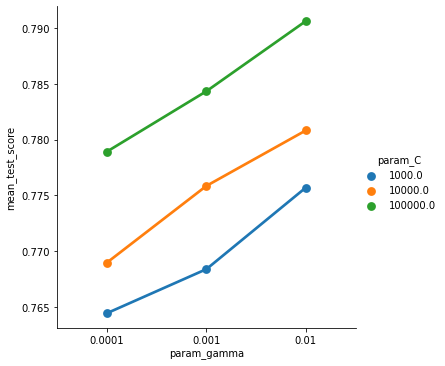

In [ ]:
svm = SVC(probability=True)

#Aplicamos grid search para los parametros
parametros={'C': [1e3, 1e4, 1e5],'gamma': [0.0001, 0.001, 0.01]}
svm_cv=GridSearchCV(svm,parametros,cv=10)
svm_cv.fit(X_train_scaled, y_train_scaled)

#para ver los parametros del mejor modelo
print('Best params for SVM:')
print(svm_cv.best_params_)

#Guardamos el mejor modelo para luego obtener sus reusltados de validacion
svm = svm_cv.best_estimator_

#transformamos los reusltados de la grilla en un dataframe
grid_results = pd.DataFrame(svm_cv.cv_results_)

#graficamos los puntaje obtenidos segun cada parametro analizado
sn.catplot(x="param_gamma", y="mean_test_score", hue="param_C", kind="point",data=grid_results);


# Evaluación de los Modelos

## Utilizar los Datos Desbalanceados para Evaluar el Modelo.

In [ ]:
ruta_data_set = '/content/gdrive/MyDrive/Colab Notebooks/BankloanFULL2021_preprocess.xlsx'
data_set1 = pd.read_excel(ruta_data_set, sheet_name='Sheet1', index_col=0)
data_set1.tail()

,Edad,Prom_NumTarjCred,Prom_NumTransWeb,LN_Ingreso,LN_Prom_CreditMes,LN_Prom_MargenComp,Genero_M,FUGA_NF,EstCivil_Casado_si,NivelEduc_Univ_si
5600,0.169231,0.000000,0.00000,0.224292,0.060761,0.594586,0,0,0,1
5601,0.276923,0.111111,0.03912,0.231164,0.061200,0.571985,1,0,0,1
5602,0.230769,0.000000,0.00978,0.179464,0.061090,0.595136,1,0,1,0
5603,0.661538,0.000000,0.00000,0.675894,0.061200,0.654833,0,0,0,1
5604,0.076923,0.074074,0.00000,0.185450,0.061310,0.594586,1,0,0,1


In [ ]:
# Datos Desbalanceados

y = data_set1['FUGA_NF']
data_set1.drop('FUGA_NF', axis=1, inplace=True)
X = data_set1

In [ ]:
# Datos Desbalanceados

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [ ]:
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

## Regresión Logística

In [ ]:
X_test_reg03 = X_test[columns_remaining_list(X_test)]
Ac_reg = regresion.score(X_test_reg03, y_test)
print('Accuracy of Decision trees: {:.2f}'.format(Ac_reg))

Accuracy of Decision trees: 0.79


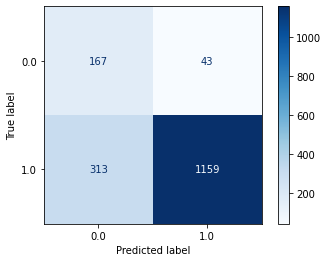

In [ ]:
Y_pred_regresion = regresion.predict(X_test_reg03) # Eliminando las Columnas Elimminadas el Logit Reg
metrics.plot_confusion_matrix(regresion, X_test_reg03, y_test, values_format='.6g', cmap='Blues') 
plt.show()

In [ ]:
Reporte = classification_report(y_test, Y_pred_regresion)
print('Reporte de clasificacion: ')
print(Reporte)

Reporte de clasificacion: 
              precision    recall  f1-score   support

           0       0.35      0.80      0.48       210
           1       0.96      0.79      0.87      1472

    accuracy                           0.79      1682
   macro avg       0.66      0.79      0.68      1682
weighted avg       0.89      0.79      0.82      1682



In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, regresion.predict_proba(X_test_reg03)[:,1])
auc = roc_auc_score(y_test, Y_pred_regresion)
print('AUC: %.3f' % auc)

AUC: 0.791


In [ ]:
result_table = result_table.append({'classifiers': 'Regresion logistica','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

## Árboles de Decisión

In [ ]:
arbol

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=2, max_features=None, max_leaf_nodes=5,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Accuracy of Decision trees: 0.80


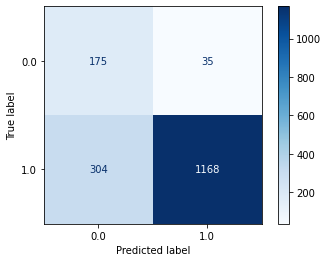

Reporte de clasificacion: 
              precision    recall  f1-score   support

           0       0.37      0.83      0.51       210
           1       0.97      0.79      0.87      1472

    accuracy                           0.80      1682
   macro avg       0.67      0.81      0.69      1682
weighted avg       0.90      0.80      0.83      1682

AUC: 0.813


In [ ]:
# Accuracy
Ac_tree = arbol.score(X_test, y_test) #con el modelo entrenado en entrenamiento (arbol)
print('Accuracy of Decision trees: {:.2f}'.format(Ac_tree))

#obtenemos el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_tree = arbol.predict(X_test)

#matriz de confusion
metrics.plot_confusion_matrix(arbol, X_test, y_test, values_format='.6g', cmap='Blues') 
plt.show()  

#Reporte de clasificacion
Reporte = classification_report(y_test, Y_pred_tree)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test, arbol.predict_proba(X_test)[:,1])
auc = roc_auc_score(y_test, Y_pred_tree)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de reusltados
result_table = result_table.append({'classifiers': 'Arbol de decisión','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)


## K-Vecinos mas cercanos



Accuracy of k-vecinos mas cercanos: 0.89


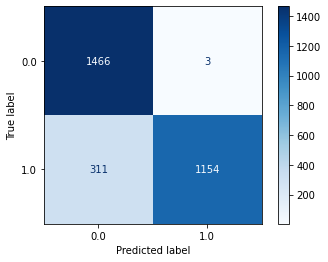

Reporte de clasificacion: 
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      1469
         1.0       1.00      0.79      0.88      1465

    accuracy                           0.89      2934
   macro avg       0.91      0.89      0.89      2934
weighted avg       0.91      0.89      0.89      2934

AUC: 0.893


In [ ]:
# Accuracy
Ac_knn = Knn.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Accuracy of k-vecinos mas cercanos: {:.2f}'.format(Ac_knn))

#obtenemos el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_knn = Knn.predict(X_test_scaled)

#matriz de confusion
metrics.plot_confusion_matrix(Knn, X_test_scaled, y_test_scaled, values_format='.6g', cmap='Blues') 
plt.show()  

#Reporte de clasificacion
Reporte = classification_report(y_test_scaled, Y_pred_knn)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, Knn.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_knn)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de reusltados
result_table = result_table.append({'classifiers': 'K-vecinos mas cercanos','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)


## Random forest

Accuracy of random forest: 0.89


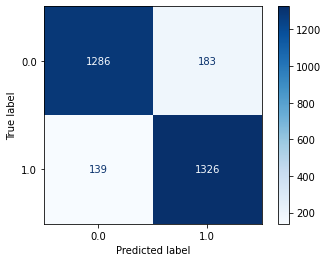

Reporte de clasificacion: 
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89      1469
         1.0       0.88      0.91      0.89      1465

    accuracy                           0.89      2934
   macro avg       0.89      0.89      0.89      2934
weighted avg       0.89      0.89      0.89      2934

AUC: 0.890


In [ ]:
# Accuracy
Ac_rf = rf.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Accuracy of random forest: {:.2f}'.format(Ac_rf))

#obtenemos el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_rf = rf.predict(X_test_scaled)

#matriz de confusion
metrics.plot_confusion_matrix(rf, X_test_scaled, y_test_scaled, values_format='.6g', cmap='Blues') 
plt.show()  

#Reporte de clasificacion
Reporte = classification_report(y_test_scaled, Y_pred_rf)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, rf.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_rf)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de reusltados
result_table = result_table.append({'classifiers': 'Random forest','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)


## Red Neuronal

Accuracy of red neuronal: 0.81


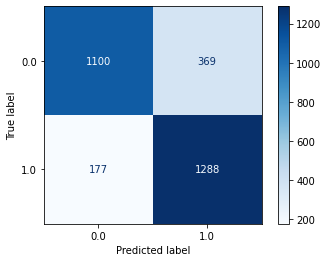

Reporte de clasificacion: 
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80      1469
         1.0       0.78      0.88      0.83      1465

    accuracy                           0.81      2934
   macro avg       0.82      0.81      0.81      2934
weighted avg       0.82      0.81      0.81      2934

AUC: 0.814


In [ ]:
# Accuracy
Ac_red = red.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Accuracy of red neuronal: {:.2f}'.format(Ac_red))

#obtenemos el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_red = red.predict(X_test_scaled)

#matriz de confusion
metrics.plot_confusion_matrix(red, X_test_scaled, y_test_scaled, values_format='.6g', cmap='Blues') 
plt.show()  

#Reporte de clasificacion
Reporte = classification_report(y_test_scaled, Y_pred_red)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, red.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_red)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de reusltados
result_table = result_table.append({'classifiers': 'Red neuronal','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

## Support Vector Machine

Accuracy of support vector machine: 0.79


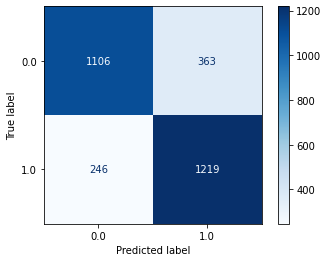

Reporte de clasificacion: 
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78      1469
         1.0       0.77      0.83      0.80      1465

    accuracy                           0.79      2934
   macro avg       0.79      0.79      0.79      2934
weighted avg       0.79      0.79      0.79      2934

AUC: 0.792


In [ ]:
# Accuracy
Ac_svm = svm.score(X_test_scaled, y_test_scaled) #con el modelo entrenado en entrenamiento
print('Accuracy of support vector machine: {:.2f}'.format(Ac_svm))

#obtenemos el valor de la variable objetivo a partir de los datos de la variable independiente de prueba
Y_pred_svm = svm.predict(X_test_scaled)

#matriz de confusion
metrics.plot_confusion_matrix(svm, X_test_scaled, y_test_scaled, values_format='.6g', cmap='Blues') 
plt.show()  

#Reporte de clasificacion
Reporte = classification_report(y_test_scaled, Y_pred_svm)
print('Reporte de clasificacion: ')
print(Reporte)

# Calculo de AUC
fpr, tpr, thresholds = roc_curve(y_test_scaled, svm.predict_proba(X_test_scaled)[:,1])
auc = roc_auc_score(y_test_scaled, Y_pred_svm)
print('AUC: %.3f' % auc)

#Para agregar a la tabla de reusltados
result_table = result_table.append({'classifiers': 'Suport vector machine','fpr':fpr,'tpr':tpr, 'auc':auc}, ignore_index=True)

## Curvas ROC

In [ ]:
result_table

,classifiers,fpr,tpr,auc
0,Regresion logistica,"[0.0, 0.0, 0.0, 0.004761904761904762, 0.004761...","[0.0, 0.0006793478260869565, 0.010869565217391...",0.791301
1,Arbol de decisión,"[0.0, 0.09047619047619047, 0.16666666666666666...","[0.0, 0.6304347826086957, 0.7934782608695652, ...",0.813406
2,K-vecinos mas cercanos,"[0.0, 0.0020422055820285907, 0.002042205582028...","[0.0, 0.7174061433447099, 0.8730375426621161, ...",0.892836
3,Random forest,"[0.0, 0.0, 0.0, 0.0020422055820285907, 0.00204...","[0.0, 0.0006825938566552901, 0.402047781569965...",0.890272
4,Red neuronal,"[0.0, 0.0, 0.0, 0.0013614703880190605, 0.00136...","[0.0, 0.0006825938566552901, 0.003412969283276...",0.813995
5,Suport vector machine,"[0.0, 0.0, 0.0, 0.0006807351940095302, 0.00068...","[0.0, 0.004095563139931741, 0.0457337883959044...",0.792488


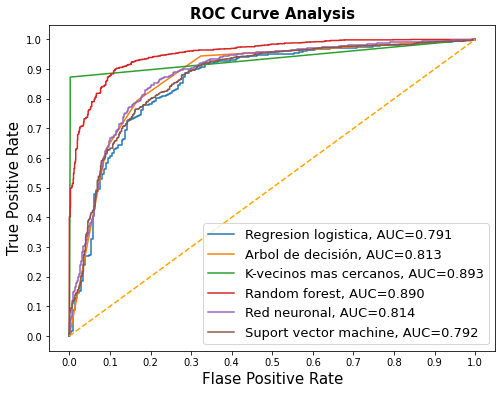

In [ ]:
result_table.set_index('classifiers', inplace=True)

#plot
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [ ]:
%cd /content
drive.mount('/content/gdrive')
dump(rf, 'gdrive/My Drive/modelo_entrenado.joblib')

/content
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


['gdrive/My Drive/modelo_entrenado.joblib']